In [38]:
from __future__ import annotations

import operator
from pathlib import Path
from typing import TypedDict, List, Optional, Literal, Annotated

from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.types import Send

from langchain_groq import ChatGroq 
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv

load_dotenv()


True

In [143]:
# -----------------------------
# 1) Schemas
# -----------------------------
class Task(BaseModel):
    id: int
    title: str

    goal: str = Field(
        ...,
        description="One sentence describing what the reader should be able to do/understand after this section.",
    )
    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=6,
        description="3–6 concrete, non-overlapping subpoints to cover in this section.",
    )
    target_words: int = Field(..., description="Target word count for this section (120–550).")

    tags: List[str] = Field(default_factory=list)
    requires_research: bool = False
    requires_citations: bool = False
    requires_code: bool = False


class Plan(BaseModel):
    blog_title: str
    audience: str
    tone: str
    blog_kind: Literal["explainer", "tutorial", "news_roundup", "comparison", "system_design"] = "explainer"
    constraints: List[str] = Field(default_factory=list)
    tasks: List[Task]


class EvidenceItem(BaseModel):
    title: str
    url: str
    published_at: Optional[str] = None  # keep if Tavily provides; DO NOT rely on it
    snippet: Optional[str] = None
    source: Optional[str] = None


class RouterDecision(BaseModel):
    needs_research: bool
    mode: Literal["closed_book", "hybrid", "open_book"]
    queries: List[str] = Field(default_factory=list)


class EvidencePack(BaseModel):
    evidence: List[EvidenceItem] = Field(default_factory=list)

In [144]:
class State(TypedDict):
    topic: str

    # routing / research
    mode: str
    needs_research: bool
    queries: List[str]
    evidence: List[EvidenceItem]
    plan: Optional[Plan]

    # workers
    sections: Annotated[List[tuple[int, str]], operator.add]  # (task_id, section_md)
    final: str

In [145]:
# -----------------------------
# 2) LLM
# -----------------------------
llm = ChatGroq(model_name="openai/gpt-oss-120b")

In [183]:
# -----------------------------
# 3) Router (decide upfront)
# -----------------------------
ROUTER_SYSTEM = """You are a routing module for a technical blog planner.

Decide whether web research is needed BEFORE planning.

Modes:
- closed_book (needs_research=false):
  Evergreen topics where correctness does not depend on recent facts (concepts, fundamentals).
- hybrid (needs_research=true):
  Mostly evergreen but needs up-to-date examples/tools/models to be useful.
- open_book (needs_research=true):
  Mostly volatile: weekly roundups, "this week", "latest", rankings, pricing, policy/regulation.

If needs_research=true:
- Output 3 high-signal queries.
- Queries should be scoped and specific (avoid generic queries like just "AI" or "LLM").
- If user asked for "last week/this week/latest", reflect that constraint IN THE QUERIES.
"""

def router_node(state: State) -> dict:
    
    topic = state["topic"]
    decider = llm.with_structured_output(RouterDecision)
    decision = decider.invoke(
        [
            SystemMessage(content=ROUTER_SYSTEM),
            HumanMessage(content=f"Topic: {topic}"),
        ]
    )
    print("router_node")
    return {
        "needs_research": decision.needs_research,
        "mode": decision.mode,
        "queries": decision.queries,
    }

def route_next(state: State) -> str:
    return "research" if state["needs_research"] else "orchestrator"

In [192]:
# -----------------------------
# 4) Research (Tavily) 
# -----------------------------
def _tavily_search(query: str, max_results: int =  1) -> List[dict]:
    
    tool = TavilySearchResults(max_results=max_results)
    results = tool.invoke({"query": query})

    normalized: List[dict] = []
    for r in results or []:
        normalized.append(
            {
                "title": r.get("title") or "",
                "url": r.get("url") or "",
                "snippet": r.get("content") or r.get("snippet") or "",
                "published_at": r.get("published_date") or r.get("published_at"),
                "source": r.get("source"),
            }
        )
    return normalized


RESEARCH_SYSTEM = """You are a research synthesizer for technical writing.

Given raw web search results, produce a deduplicated list of EvidenceItem objects.

Rules:
- Only include items with a non-empty url.
- Prefer relevant + authoritative sources (company blogs, docs, reputable outlets).
- If a published date is explicitly present in the result payload, keep it as YYYY-MM-DD.
  If missing or unclear, set published_at=null. Do NOT guess.
- Keep snippets short.
- Deduplicate by URL.
"""

def research_node(state: State) -> dict:

    # take the first 10 queries from state
    queries = (state.get("queries", []) or [])
    max_results = 2

    raw_results: List[dict] = []

    for q in queries:
        raw_results.extend(_tavily_search(q, max_results=max_results))

    if not raw_results:
        return {"evidence": []}

    extractor = llm.with_structured_output(EvidencePack)
    pack = extractor.invoke(
        [
            SystemMessage(content=RESEARCH_SYSTEM),
            HumanMessage(content=f"Raw results:\n{raw_results}"),
        ]
    )

    # Deduplicate by URL
    dedup = {}
    for e in pack.evidence:
        if e.url:
            dedup[e.url] = e
    print("research")
    return {"evidence": list(dedup.values())}

In [193]:
# -----------------------------
# 5) Orchestrator (Plan)
# -----------------------------
ORCH_SYSTEM = """You are a senior technical writer and developer advocate.
Your job is to produce a highly actionable outline for a technical blog post.

Hard requirements:
- Create 3 sections (tasks) suitable for the topic and audience.
- Each task must include:
  1) goal (1 sentence)
  2) 3–6 bullets that are concrete, specific, and non-overlapping
  3) target word count (120–550)

Quality bar:
- Assume the reader is a developer; use correct terminology.
- Bullets must be actionable: build/compare/measure/verify/debug.
- Ensure the overall plan includes at least 2 of these somewhere:
  * minimal code sketch / MWE (set requires_code=True for that section)
  * edge cases / failure modes
  * performance/cost considerations
  * security/privacy considerations (if relevant)
  * debugging/observability tips

Grounding rules:
- Mode closed_book: keep it evergreen; do not depend on evidence.
- Mode hybrid:
  - Use evidence for up-to-date examples (models/tools/releases) in bullets.
  - Mark sections using fresh info as requires_research=True and requires_citations=True.
- Mode open_book:
  - Set blog_kind = "news_roundup".
  - Every section is about summarizing events + implications.
  - DO NOT include tutorial/how-to sections unless user explicitly asked for that.
  - If evidence is empty or insufficient, create a plan that transparently says "insufficient sources"
    and includes only what can be supported.

Output must strictly match the Plan schema.
"""

def orchestrator_node(state: State) -> dict:
    planner = llm.with_structured_output(Plan)

    evidence = state.get("evidence", [])
    mode = state.get("mode", "closed_book")

    plan = planner.invoke(
        [
            SystemMessage(content=ORCH_SYSTEM),
            HumanMessage(
                content=(
                    f"Topic: {state['topic']}\n"
                    f"Mode: {mode}\n\n"
                    f"Evidence (ONLY use for fresh claims; may be empty):\n"
                    f"{[e.model_dump() for e in evidence][:16]}"
                )
            ),
        ]
    )
    print("orch")
    return {"plan": plan}

In [194]:
# -----------------------------
# 6) Fanout
# -----------------------------
def fanout(state: State):
    return [
        Send(
            "worker",
            {
                "task": task.model_dump(),
                "topic": state["topic"],
                "mode": state["mode"],
                "plan": state["plan"].model_dump(),
                "evidence": [e.model_dump() for e in state.get("evidence", [])],
            },
        )
        for task in state["plan"].tasks
    ]

In [195]:
# -----------------------------
# 7) Worker (write one section)
# -----------------------------
WORKER_SYSTEM = """You are a senior technical writer and developer advocate.
Write ONE section of a technical blog post in Markdown.

Hard constraints:
- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).
- Stay close to Target words (±15%).
- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).
- Start with a '## <Section Title>' heading.

Scope guard:
- If blog_kind == "news_roundup": do NOT turn this into a tutorial/how-to guide.
  Do NOT teach web scraping, RSS, automation, or "how to fetch news" unless bullets explicitly ask for it.
  Focus on summarizing events and implications.

Grounding policy:
- If mode == open_book:
  - Do NOT introduce any specific event/company/model/funding/policy claim unless it is supported by provided Evidence URLs.
  - For each event claim, attach a source as a Markdown link: ([Source](URL)).
  - Only use URLs provided in Evidence. If not supported, write: "Not found in provided sources."
- If requires_citations == true:
  - For outside-world claims, cite Evidence URLs the same way.
- Evergreen reasoning is OK without citations unless requires_citations is true.

Code:
- If requires_code == true, include at least one minimal, correct code snippet relevant to the bullets.

Style:
- Short paragraphs, bullets where helpful, code fences for code.
- Avoid fluff/marketing. Be precise and implementation-oriented.
"""

def worker_node(payload: dict) -> dict:
    
    task = Task(**payload["task"])
    plan = Plan(**payload["plan"])
    evidence = [EvidenceItem(**e) for e in payload.get("evidence", [])]
    topic = payload["topic"]
    mode = payload.get("mode", "closed_book")

    bullets_text = "\n- " + "\n- ".join(task.bullets)

    evidence_text = ""
    if evidence:
        evidence_text = "\n".join(
            f"- {e.title} | {e.url} | {e.published_at or 'date:unknown'}".strip()
            for e in evidence[:20]
        )

    section_md = llm.invoke(
        [
            SystemMessage(content=WORKER_SYSTEM),
            HumanMessage(
                content=(
                    f"Blog title: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Constraints: {plan.constraints}\n"
                    f"Topic: {topic}\n"
                    f"Mode: {mode}\n\n"
                    f"Section title: {task.title}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Tags: {task.tags}\n"
                    f"requires_research: {task.requires_research}\n"
                    f"requires_citations: {task.requires_citations}\n"
                    f"requires_code: {task.requires_code}\n"
                    f"Bullets:{bullets_text}\n\n"
                    f"Evidence (ONLY use these URLs when citing):\n{evidence_text}\n"
                )
            ),
        ]
    ).content.strip()
    print("worker")
    return {"sections": [(task.id, section_md)]}

In [196]:
# -----------------------------
# 8) Reducer (merge + save)
# -----------------------------
def reducer_node(state: State) -> dict:

    plan = state["plan"]

    ordered_sections = [md for _, md in sorted(state["sections"], key=lambda x: x[0])]
    body = "\n\n".join(ordered_sections).strip()
    final_md = f"# {plan.blog_title}\n\n{body}\n"

    filename = f"{plan.blog_title}.md"
    Path(filename).write_text(final_md, encoding="utf-8")
    print("reducer_node")
    return {"final": final_md}

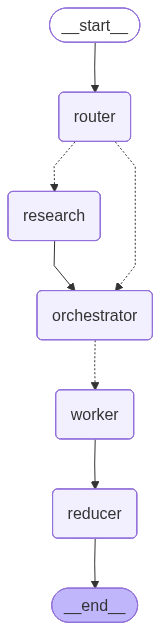

In [197]:
# -----------------------------
# 9) Build graph
# -----------------------------
g = StateGraph(State)
g.add_node("router", router_node)
g.add_node("research", research_node)
g.add_node("orchestrator", orchestrator_node)
g.add_node("worker", worker_node)
g.add_node("reducer", reducer_node)

g.add_edge(START, "router")
g.add_conditional_edges("router", route_next, {"research": "research", "orchestrator": "orchestrator"})
g.add_edge("research", "orchestrator")

g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)

app = g.compile()
app

In [198]:
# -----------------------------
# 10) Runner
# -----------------------------
def run(topic: str):
    out = app.invoke(
        {
            "topic": topic,
            "mode": "",
            "needs_research": False,
            "queries": [],
            "evidence": [],
            "plan": None,
            "sections": [],
            "final": "",
        }
    )

    return out

In [199]:
#run("Write a blog on Open Source LLMs in 2026")
a = run("What is current famous LLMs in the market")

router_node
research
orch
worker
worker
worker
reducer_node


In [182]:
print(a['final'])

# What’s Hot in the LLM Market: A 2025 Snapshot of Leading Models

## Market Landscape: Share and Adoption Trends of Leading LLMs

- **Traffic‑share shift** – The Azoma study tracks public usage from Dec 2024 to Dec 2025 and shows ChatGPT’s share dropping from 87 % to 68 %, while Google Gemini climbs to 18 % of total queries. ([Source](https://www.azoma.ai/insights/most-popular-large-language-models))

- **Enterprise‑share snapshot** – Typedef’s 2025 enterprise adoption data list Anthropic at 32 % of deployments, OpenAI at 25 %, Google at 20 %, with the remaining 23 % divided among Meta, Mistral and newer entrants. ([Source](https://www.typedef.ai/resources/llm-adoption-statistics))

- **Market‑size growth** – Grand View Research estimates the global LLM market at $5.6 B in 2024, expanding to $7.4 B in 2025, implying a compound annual growth rate of roughly 36.9 %. ([Source](https://www.grandviewresearch.com/industry-analysis/large-language-model-llm-market-report))

- **Enterprise pen

AttributeError: type object 'State' has no attribute 'final'

In [67]:
for event in app.stream(State):
    print(event)

InvalidUpdateError: Expected dict, got <class '__main__.State'>
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_GRAPH_NODE_RETURN_VALUE

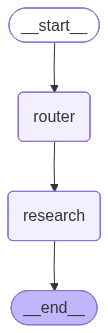

In [81]:
g = StateGraph(State)
g.add_node("router", router_node)
g.add_node("research", research_node)

g.add_edge(START, "router")
g.add_edge("router", "research")
g.add_edge("research", END)

app_1= g.compile()
app_1

In [82]:
out = app.invoke(
        {
            "topic": "Write a blog on Open Source LLMs in 2026",
            "mode": "",
            "needs_research": False,
            "queries": [],
            "evidence": [],
            "plan": None,
            "sections": [],
            "final": "",
        }
    )

router_node


APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `openai/gpt-oss-120b` in organization `org_01k8nvgdnsfccagthmhnr91z8s` service tier `on_demand` on tokens per minute (TPM): Limit 8000, Requested 25639, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}